In [2]:
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import cv2
from tensorflow.keras.preprocessing.image import img_to_array, ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetV2B0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from sklearn.model_selection import StratifiedKFold

def load_nii_file(nii_path):
    img = nib.load(nii_path)
    img_data = img.get_fdata()
    return img_data

def save_middle_slice(img_data, output_path):
    middle_slice = img_data[:, :, img_data.shape[2] // 2]
    plt.imshow(middle_slice, cmap="gray")
    plt.axis('off')
    plt.savefig(output_path, bbox_inches='tight', pad_inches=0)

train_csv = pd.read_csv("D:/College_Work/Semester_5/DL/prostate158_train/train.csv")

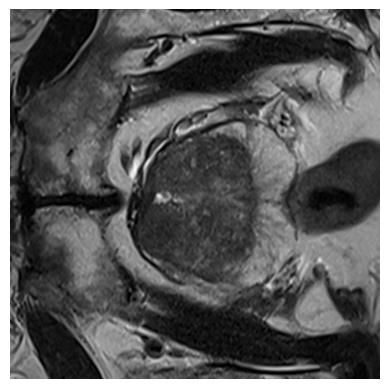

In [3]:
# Prepare image slices from .nii files
output_dir = "new_data/train"
os.makedirs(output_dir, exist_ok=True)

for index, row in train_csv.iterrows():
    t2_path = f"D:/College_Work/Semester_5/DL/prostate158_train/{row['t2']}"
    img_data = load_nii_file(t2_path)
    output_path = os.path.join(output_dir, f"patient_{row['ID']}_t2_slice.png")
    save_middle_slice(img_data, output_path)

In [4]:
def preprocess_image(img_path, target_size=(224, 224)):
    # Loading the image and resize it
    image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    image_resized = cv2.resize(image, target_size)
    
    # Converting grayscale image to RGB by stacking the single channel
    image_rgb = cv2.cvtColor(image_resized, cv2.COLOR_GRAY2RGB)
    
    # Converting the image to array and normalize pixel values to [0, 1]
    image_array = img_to_array(image_rgb) / 255.0
    return image_array

def create_label(mask_path):
    mask_data = load_nii_file(mask_path)
    has_tumor = np.any(mask_data > 0)
    return 1 if has_tumor else 0

# Creating a dataset of images and labels
def build_dataset(csv_file, base_dir, target_size=(224, 224)):
    images = []
    labels = []

    for index, row in csv_file.iterrows():
        img_path = os.path.join(base_dir, f"patient_{row['ID']}_t2_slice.png")
        label_path = f"D:/College_Work/Semester_5/DL/prostate158_train/{row['t2_tumor_reader1']}"

        if os.path.exists(img_path):
            image = preprocess_image(img_path, target_size)
            images.append(image)

            if os.path.exists(label_path):
                label = create_label(label_path)
                labels.append(label)
            else:
                labels.append(0)

    return np.array(images), np.array(labels)

In [5]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.utils import class_weight
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_images, train_labels = build_dataset(train_csv, output_dir)

X_train, X_val, y_train, y_val = train_test_split(train_images, train_labels, test_size=0.2, random_state=42)

# Creating an ImageDataGenerator with data augmentation
datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Calculating class weights for handling imbalanced data
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights = dict(enumerate(class_weights))

In [6]:
# Function to create the model
def create_model(input_shape=(224, 224, 3)):
    base_model = EfficientNetV2B0(weights='imagenet', include_top=False, input_shape=input_shape)

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    output = Dense(1, activation='sigmoid', kernel_regularizer=l2(0.001))(x)  # Added L2 regularization

    model = Model(inputs=base_model.input, outputs=output)
    
    # Compile the model with Adam optimizer and a lower learning rate
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Data augmentation
train_datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator()

# Implementing Stratified KFold to maintain class balance
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for train_index, val_index in skf.split(train_images, train_labels):
    X_train, X_val = train_images[train_index], train_images[val_index]
    y_train, y_val = train_labels[train_index], train_labels[val_index]

    # Creating the training and validation data generators
    train_generator = train_datagen.flow(X_train, y_train, batch_size=32)
    val_generator = val_datagen.flow(X_val, y_val, batch_size=32)

    model = create_model()

    # Callbacks: Early stopping and learning rate reduction
    early_stopping = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-5)

    # Training the model
    history = model.fit(
        train_generator,
        validation_data=val_generator,
        epochs=50,
        callbacks=[early_stopping, reduce_lr]
    )

Epoch 1/50
3/3 [==============================] - 67s 12s/step - loss: 0.9031 - accuracy: 0.5684 - val_loss: 0.6995 - val_accuracy: 0.4167 - lr: 1.0000e-04
Epoch 2/50
3/3 [==============================] - 28s 10s/step - loss: 1.1022 - accuracy: 0.4737 - val_loss: 0.7054 - val_accuracy: 0.4167 - lr: 1.0000e-04
Epoch 3/50
3/3 [==============================] - 27s 9s/step - loss: 0.7794 - accuracy: 0.5474 - val_loss: 0.7042 - val_accuracy: 0.4167 - lr: 1.0000e-04
Epoch 4/50
3/3 [==============================] - 27s 9s/step - loss: 0.9848 - accuracy: 0.5158 - val_loss: 0.7084 - val_accuracy: 0.4167 - lr: 1.0000e-04
Epoch 5/50
3/3 [==============================] - 27s 9s/step - loss: 1.0031 - accuracy: 0.5263 - val_loss: 0.7130 - val_accuracy: 0.4167 - lr: 5.0000e-05
Epoch 6/50
3/3 [==============================] - 26s 9s/step - loss: 0.9188 - accuracy: 0.5789 - val_loss: 0.7098 - val_accuracy: 0.4167 - lr: 5.0000e-05
Epoch 7/50
3/3 [==============================] - 27s 9s/step - loss

In [7]:
model.save('new_3_prostate_cancer_model.h5')

# Model evaluation on validation data
val_loss, val_acc = model.evaluate(val_generator)
print(f"Validation Accuracy: {val_acc * 100:.2f}%")
print(f"Validation Loss: {val_loss:.4f}")

c:\Users\Vansh Payala\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 1s 1s/step - loss: 0.6727 - accuracy: 0.6087
Validation Accuracy: 60.87%
Validation Loss: 0.6727


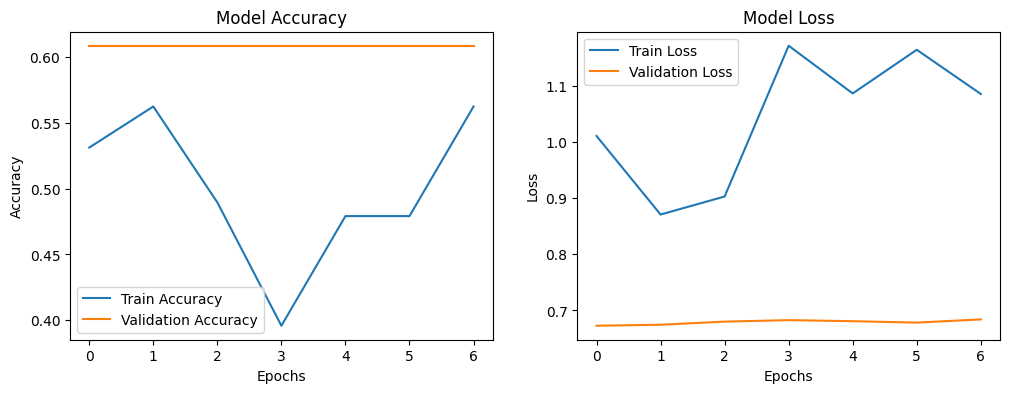

In [15]:
# Plot training and validation accuracy and loss
def plot_history(history):
    # Accuracy plot
    plt.figure(figsize=(12, 4))

    # Training and validation accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Training and validation loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

# After model.fit(), call this function
plot_history(history)

1/1 [==============================] - 2s 2s/step


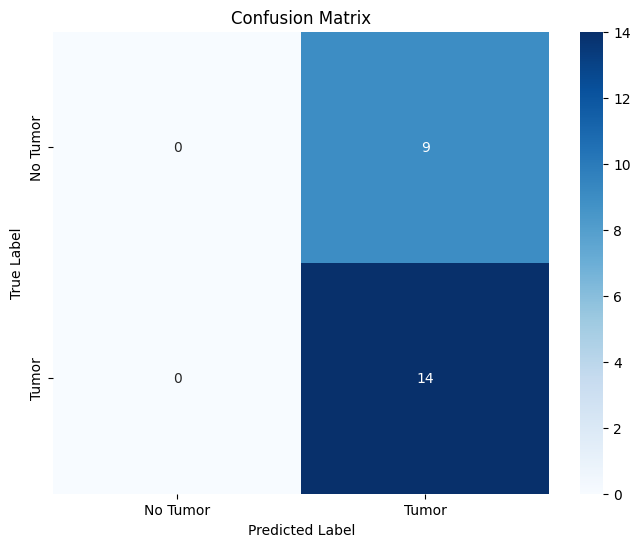

In [19]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

# After model prediction on validation data
y_pred = model.predict(val_generator)
y_pred_classes = np.where(y_pred > 0.5, 1, 0).flatten()
y_true = y_val  # Ground truth labels from validation set

# Assuming binary classification (tumor, no tumor)
class_names = ['No Tumor', 'Tumor']

# Plot confusion matrix
plot_confusion_matrix(y_true, y_pred_classes, class_names)

In [13]:
test_image_dir = "new_data/test"

# Function to preprocess the test image
def preprocess_image(image_path, target_size=(224, 224)):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, target_size)
    img = img / 255.0  # Normalize to [0, 1]
    img = np.expand_dims(img, axis=-1) 
    img = np.expand_dims(img, axis=0) 
    return img

test_images = os.listdir(test_image_dir)

preprocessed_images = [preprocess_image(os.path.join(test_image_dir, img)) for img in test_images]

In [14]:
from tensorflow.keras.models import load_model

model = load_model('new_3_prostate_cancer_model.h5')

predictions = []
for img in preprocessed_images:
    prediction = model.predict(img)
    predictions.append(prediction)

for i, pred in enumerate(predictions):
    print(f"Test image {test_images[i]}: {'Cancer' if pred > 0.5 else 'Non-Cancer'} (Probability: {pred[0][0]:.4f})")

1/1 [==============================] - 0s 147ms/step
Test image patient_24_t2_slice.png: Cancer (Probability: 0.5878)
Test image patient_25_t2_slice.png: Cancer (Probability: 0.5871)
Test image patient_26_t2_slice.png: Cancer (Probability: 0.5890)
Test image patient_27_t2_slice.png: Cancer (Probability: 0.5866)
Test image patient_28_t2_slice.png: Cancer (Probability: 0.5880)
Test image patient_29_t2_slice.png: Cancer (Probability: 0.5874)
Test image patient_30_t2_slice.png: Cancer (Probability: 0.5863)
Test image patient_31_t2_slice.png: Cancer (Probability: 0.5875)
Test image patient_32_t2_slice.png: Cancer (Probability: 0.5860)
Test image patient_33_t2_slice.png: Cancer (Probability: 0.5869)
Test image patient_34_t2_slice.png: Cancer (Probability: 0.5875)
Test image patient_35_t2_slice.png: Cancer (Probability: 0.5869)
